In [2]:
!pip install pycaret

     |████████████████████████████████| 261 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.2 MB 5.6 MB/s eta 0:00:01    |███▊                            | 1.7 MB 4.4 MB/s eta 0:00:03     |███████▋                        | 3.4 MB 4.4 MB/s eta 0:00:03     |█████████████████████           | 9.3 MB 4.5 MB/s eta 0:00:02
     |████████████████████████████████| 1.3 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 7.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 6.6 MB/s eta 0:00:011
     |████████████████████████████████| 56 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 102 kB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 248 kB 7.7 MB/s eta 0:00:01
     |█████████████

In [1]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from pycaret.classification import *
from pycaret.utils import check_metric
from datetime import timedelta, timezone, datetime
import torch
import time
from datetime import datetime

In [2]:
def setSeeds(seed = 42):
    # 랜덤 시드를 설정하여 매 코드를 실행할 때마다 동일한 결과를 얻게 합니다.
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
setSeeds(42)

In [3]:
def feature_split_user(df):
    new_df = df.copy()
    new_df["newUserID"] = df['assessmentItemID'].apply(lambda x:x[:3]) + df['userID'].astype(str)
    return new_df

def get_remain_test_data(df_test):
    get_new_id = set(df_test.loc[df_test.answerCode == -1, 'newUserID'])    
    test_data = df_test[df_test.newUserID.isin(get_new_id)]
    remain_data = df_test.drop(test_data.index)
    return test_data, remain_data
# time convert
def convert_time(s):
    timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
    return int(timestamp)

In [4]:
train_path = '/opt/ml/input/data/train_dataset/train_data.csv'
test_path = '/opt/ml/input/data/train_dataset/test_data.csv'

df_train_ori = pd.read_csv(train_path) 
df_test_ori = pd.read_csv(test_path)

df_train = feature_split_user(df_train_ori)
df_test = feature_split_user(df_test_ori)

df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)] # 맞춰야하는 row만 모아놓은 것
df_test, remain_data = get_remain_test_data(df_test)
df_train = pd.concat([df_train, remain_data])

df_train['Timestamp'] = df_train['Timestamp'].apply(convert_time)
df_test['Timestamp'] = df_test['Timestamp'].apply(convert_time)

df_train_test = pd.concat([df_train, df_test['answerCode'], df_test[df_test['answerCode'] != -1]])

In [5]:
# trian에서 각 문제 평균 뽑기
testId_mean_sum = df_train_test.groupby(['testId'])['answerCode'].agg(['mean','sum']).to_dict()
assessmentItemID_mean_sum = df_train_test.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum']).to_dict()
KnowledgeTag_mean_sum = df_train_test.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum']).to_dict()

In [6]:
# new user id 겹치는거 없음 확인
s1 = set(df_test.loc[:, 'newUserID'])
s2 = set(df_train.loc[:, 'newUserID'])
s1 & s2

set()

## Feature engineering
### 한번만 실행되도록 설정

In [7]:
def feature_engineering(df_ori):
    df = df_ori.copy()
    def assessmentItemID2item(x):
        return int(x[-3:]) - 1
    df['item'] = df.assessmentItemID.map(assessmentItemID2item)
    # testId별로 나오는 문제 갯수
    item_size = df[['assessmentItemID', 'testId']].drop_duplicates().groupby('testId').size()
    testId2maxlen = item_size.to_dict() # 중복해서 풀이할 놈들을 제거하기 위해
    
    item_max = df.groupby('testId')['item'].max()

    # 순서대로 풀지 않은 문제의 index
    not_order_index = item_max[item_max +1 != item_size].index    
    not_order_test = df.loc[df.testId.isin(not_order_index)][['assessmentItemID','testId']].drop_duplicates().sort_values('assessmentItemID')
    not_order_group = not_order_test.groupby('testId')

    not_order_ID2item = {}
    for key in not_order_group.groups:
        for i, (k, _) in enumerate(not_order_group.get_group(key).values):
            not_order_ID2item[k] = i
    
    def assessmentItemID2item_order(x):
        if x in not_order_ID2item:
            return int(not_order_ID2item[x])
        return int(x[-3:]) -1
    df['orded_item'] = df.assessmentItemID.map(assessmentItemID2item_order)
    df_group = df.groupby(['newUserID','testId'])['answerCode']
    #user 별 이전까지 맞춘개수, 현재까지 맞춘개수, 현재 정답률
    df['user_correct_answer'] = df_group.transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df_group.cumcount()
    df['user_acc'] = df['user_correct_answer'] / df['user_total_answer']
    
    #한 test안에서 마지막으로 푼 문제으로 부터 지난 시간
    df['prev_timestamp'] = df.groupby('testId')['Timestamp'].shift(0) - df.groupby('testId')['Timestamp'].shift(1)
    
    # user 별 마지막으로 푼 tag로부터 지난 시간, NaN값은 300으로 한다.
    prev_timestamp_ac = df.groupby(['newUserID', 'KnowledgeTag'])[['Timestamp']].shift()
    df['diff_time_btw_KnowledgeTag_ids'] = (df['Timestamp'] - prev_timestamp_ac['Timestamp']).fillna(300)
    
    # 각 tag 별 마지막으로 풀었을때 정답 여부
    prev_correct_ac = df.groupby(['newUserID', 'KnowledgeTag'])[['answerCode']].shift()        
    df['prev_answered_correctly'] = prev_correct_ac['answerCode'].fillna(0)
    
    #test, item, tag 별 평균 정답률
    df["test_mean"] = df.testId.map(testId_mean_sum['mean'])
    df["ItemID_mean"] = df.assessmentItemID.map(assessmentItemID_mean_sum['mean'])
    df["tag_mean"] = df.KnowledgeTag.map(KnowledgeTag_mean_sum['mean'])
    
    #test, Item, tag 별 상대적 정답률
    df['relative_test_answer'] = df['answerCode'] - df['test_mean']
    df['relative_ItemID_answer'] = df['answerCode'] - df['ItemID_mean']
    df['relative_tag_answer'] = df['answerCode'] - df['tag_mean']
    
    #이동평균선 5, 10, 15, 20, 25, 30
    df['ma5'] = df['user_acc'].fillna(0).rolling(window=5).mean()
    df['ma10'] = df['user_acc'].fillna(0).rolling(window=10).mean()
    df['ma15'] = df['user_acc'].fillna(0).rolling(window=15).mean()
    df['ma20'] = df['user_acc'].fillna(0).rolling(window=20).mean()
    df['ma25'] = df['user_acc'].fillna(0).rolling(window=25).mean()
    df['ma30'] = df['user_acc'].fillna(0).rolling(window=30).mean()
    
    #MACD
    df['MACD'] = df['ma15'] - df['ma25']
    
    #Standard Deviation 5,10, 15, 20, 25, 30
    df['sd5'] = df['user_acc'].fillna(0).rolling(window=5).std()
    df['sd10'] = df['user_acc'].fillna(0).rolling(window=10).std()
    df['sd15'] = df['user_acc'].fillna(0).rolling(window=15).std()
    df['sd20'] = df['user_acc'].fillna(0).rolling(window=20).std()
    df['sd25'] = df['user_acc'].fillna(0).rolling(window=25).std()
    df['sd30'] = df['user_acc'].fillna(0).rolling(window=30).std()
    
    #볼린저 밴드
    df['Upper BollingerBand'] = df['ma10'] + (df['sd10'] * 3)
    df['Lower BollingerBand'] = df['ma10'] - (df['sd10'] * 3)
    
    #이전에 같은 item, tag 몇 번 풀었는지
    df['prior_ItemID_frequency'] = df.groupby(['newUserID', 'assessmentItemID']).cumcount()
    df['prior_tag_frequency'] = df.groupby(['newUserID', 'KnowledgeTag']).cumcount()
    
    #망각 곡선TOD
    return df

In [8]:
if os.path.exists("fe_train2.csv") and os.path.exists("fe_test2.csv"):
    FE_train = pd.read_csv("fe_train2.csv")
    FE_test = pd.read_csv("fe_test2.csv")
    FE_train.drop('Unnamed: 0', axis=1, inplace=True)
    FE_test.drop('Unnamed: 0', axis=1, inplace=True)
    print("cache dataset complete")
else:
    print("working on feature engineering.")
    FE_train = feature_engineering(df_train)
    FE_test = feature_engineering(df_test)
    FE_train.to_csv('fe_train2.csv')
    FE_test.to_csv('fe_test2.csv')
    print("save dataset")

cache dataset complete


In [23]:
# 추가적인 feature engineering은 여기서 진행해주시면 됩니다.
def add_feature(df_ori):
    df = df_ori.copy()
    df["test_sum"] = df.testId.map(testId_mean_sum['sum'])
    df["ItemID_sum"] = df.assessmentItemID.map(assessmentItemID_mean_sum['sum'])
    df["tag_sum"] = df.KnowledgeTag.map(KnowledgeTag_mean_sum['sum'])
    df['grade'] = df['testId'].map(lambda x: x[2]).astype('category')
    
    return df
FE_train = add_feature(FE_train)
FE_test = add_feature(FE_test)


## catergorical data preprocessing

In [24]:
a = set(FE_train.assessmentItemID)
b = set(FE_test.assessmentItemID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.testId)
b = set(FE_test.testId)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.KnowledgeTag)
b = set(FE_test.KnowledgeTag)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.newUserID)
b = set(FE_test.newUserID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

9454
9399
9399
**************************************************
1537
1526
1526
**************************************************
912
912
912
**************************************************
18995
744
0
**************************************************


In [25]:
from sklearn.preprocessing import LabelEncoder
# test data와 train data를 함께 handling하기 때문에 이전과 이후의 차이가 있는지 확인
def categori_preprocessing(PP_train, PP_test):
    cate_cols = ['newUserID', 'assessmentItemID', 'testId', 'KnowledgeTag']  # 문항, 시험지, 문항 태그
    PP_full = pd.concat([PP_train, PP_test])
    
    print("처리 시작")
    for col in cate_cols:
        label_encoder = LabelEncoder()
        #For UNKNOWN class
        a = PP_full[col].unique().tolist() + ['unknown']
        label_encoder.fit(a)

        #모든 컬럼이 범주형이라고 가정
        PP_full[col] = PP_full[col].astype(str)
        test = label_encoder.transform(PP_full[col])
        PP_full[col] = test
        PP_full[col] = PP_full[col].astype('category')
        print(col + "처리")
        
    return PP_full[:len(PP_train)], PP_full[len(PP_train):]

PP_train, PP_test = categori_preprocessing(FE_train, FE_test)

처리 시작
newUserID처리
assessmentItemID처리
testId처리
KnowledgeTag처리


In [26]:
a = set(PP_train.assessmentItemID)
b = set(PP_test.assessmentItemID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.testId)
b = set(PP_test.testId)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.KnowledgeTag)
b = set(PP_test.KnowledgeTag)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.newUserID)
b = set(PP_test.newUserID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

9454
9399
9399
**************************************************
1537
1526
1526
**************************************************
912
912
912
**************************************************
18995
744
0
**************************************************


In [385]:
# 문제 없다면 다시 train test로 분배!
df_train, df_test = PP_train, PP_test

# validation split

In [386]:
# 맞춰야하는 문항 ID 파악
set_assessmentItemID = set(df_test.loc[df_test.answerCode == -1, 'assessmentItemID'].values) # 문제별 ID
set_testId = set(df_test.loc[df_test.answerCode == -1, 'testId'].values) # 시험지별 ID
set_tag = set(df_test.loc[df_test.answerCode == -1, 'KnowledgeTag'].values) # 시험지별 ID

In [387]:
def get_full_valid_split(df_ori, train_filter=None, val_filter="assessmentItemID", ratio = 0.1):
    random.seed(0)
    df = df_ori.copy()
    if val_filter == "assessmentItemID":
        df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))]
    elif val_filter == "testId":
        df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.testId.isin(set_testId))]
    elif val_filter == "KnowledgeTag":
         df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.KnowledgeTag.isin(set_tag))]

    df_val = df_val.sample(frac=ratio, random_state = 0)
    
    if train_filter == "test":
        df_train = df[df['testId'] != df['testId'].shift(-1)]
    elif train_filter == "user":
        df_train = df[df['newUserID'] != df['newUserID'].shift(-1)]
    else:
        df_train = df


    df_train = df_train[df_train.index.isin(df_val.index) == False]
    print(set(df_train.index) & set(df_val.index))

    return df_train, df_val

## train setting

In [419]:
train_filter = 'test' # test, user, none
val_filter = "assessmentItemID" # assessmentItemID, testId, KnowledgeTag

FEATS = ['item', 'orded_item',
       'user_correct_answer', 'user_total_answer', 'user_acc',
       'prev_timestamp', 'diff_time_btw_KnowledgeTag_ids', 'prev_answered_correctly',
         'test_mean', 'ItemID_mean', 'tag_mean',
'ma5', 'ma10', 'ma15', 'ma20', 'ma25', 'ma30', 'MACD', 'sd5', 'sd10', 'sd15', 'sd20', 'sd25', 'sd30', 'Upper BollingerBand',
'Lower BollingerBand', 'prior_ItemID_frequency', 'prior_tag_frequency']

'''
'relative_test_answer', 'relative_ItemID_answer', 'relative_tag_answer',
'''
         
#categorical_features = ['assessmentItemID'] # KnowledgeTag, newUserID, testId, assessmentItemID
categorical_features = ['KnowledgeTag', 'testId', 'assessmentItemID', 'newUserID']
# categorical_features = []
numeric_features = []
FEATS = FEATS + categorical_features + numeric_features

In [420]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 500, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': 42,
    'verbose': -1,
    'n_jobs': -1,    
}

In [421]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
def group_train(group_df_train, group_df_val, group_df_test, FEATS):
    
    group_train_answer = group_df_train['answerCode']
    group_train = group_df_train.drop(['answerCode'], axis=1)

    group_test_answer = group_df_val['answerCode']
    group_test = group_df_val.drop(['answerCode'], axis=1)

    group_lgb_train = lgb.Dataset(group_train[FEATS], group_train_answer, free_raw_data=False)
    group_lgb_test = lgb.Dataset(group_test[FEATS], group_test_answer, free_raw_data=False)
    
    model = lgb.train(
                    model_params, 
                    group_lgb_train,
                    valid_sets=[group_lgb_train, group_lgb_test],
                    verbose_eval=100,
                    categorical_feature=categorical_features
                )

    group_preds = model.predict(group_test[FEATS])
    acc = accuracy_score(group_test_answer, np.where(group_preds >= 0.5, 1, 0))
    auc = roc_auc_score(group_test_answer, group_preds)
    test_preds = model.predict(group_df_test[FEATS])
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    lgb.plot_importance(model)
    return test_preds, auc


[1학년]   train size : 56644 
 	 test size : 75 
 	 val size :  229
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.91593	valid_1's auc: 0.877838
Early stopping, best iteration is:
[97]	training's auc: 0.913772	valid_1's auc: 0.878612
VALID AUC : 0.8786119711042312 ACC : 0.8209606986899564


[2학년]   train size : 53702 
 	 test size : 87 
 	 val size :  283
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.921795	valid_1's auc: 0.893347
Early stopping, best iteration is:
[31]	training's auc: 0.873725	valid_1's auc: 0.895114
VALID AUC : 0.8951140722794265 ACC : 0.8091872791519434


[3학년]   train size : 54560 
 	 test size : 85 
 	 val size :  283
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.921771	valid_1's auc: 0.785571
Early stopping, best iteration is:
[28]	training's auc: 0.87343	valid_1's auc: 0.803407
VALID AUC : 0.8034065823800923 ACC : 0.7314487632508834


[4학년]   tra

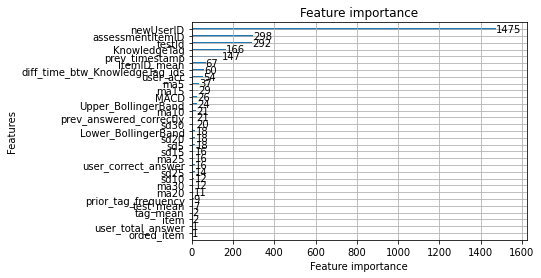

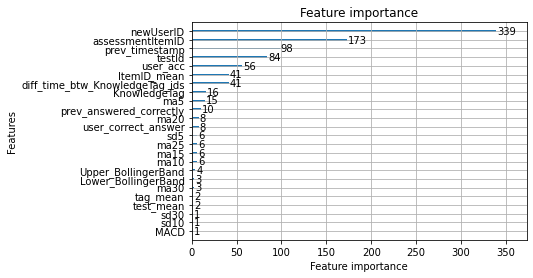

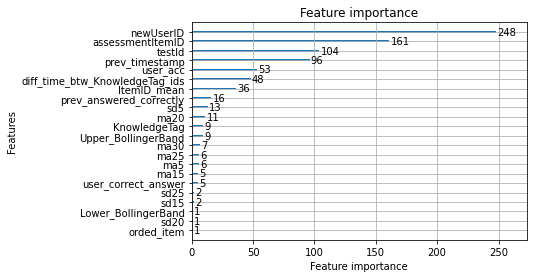

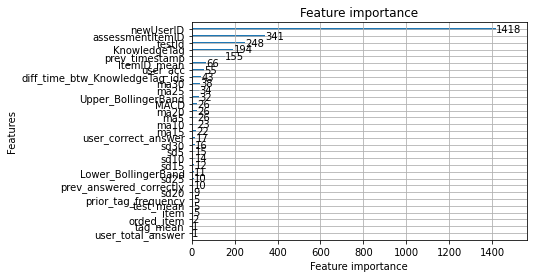

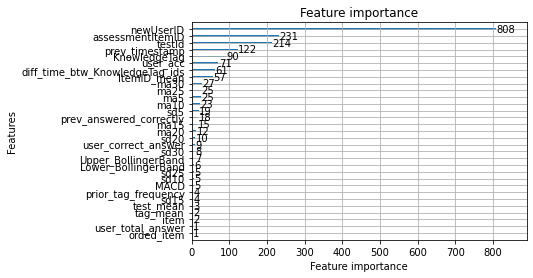

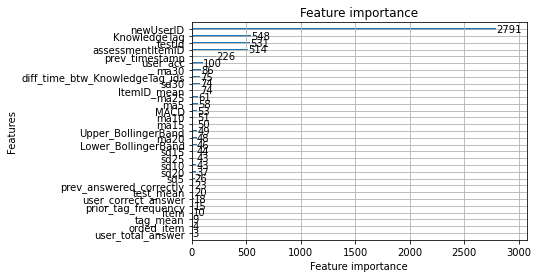

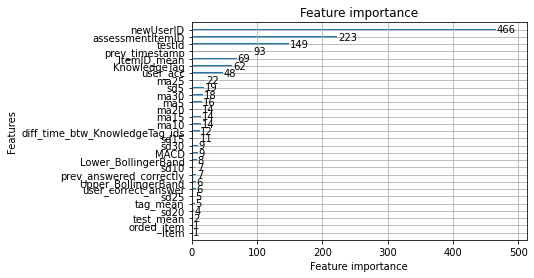

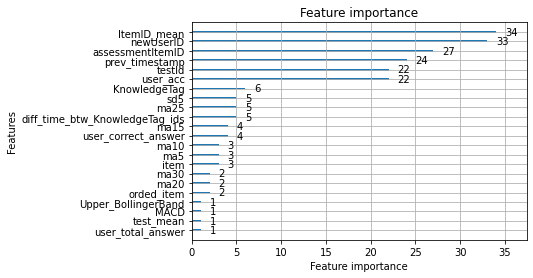

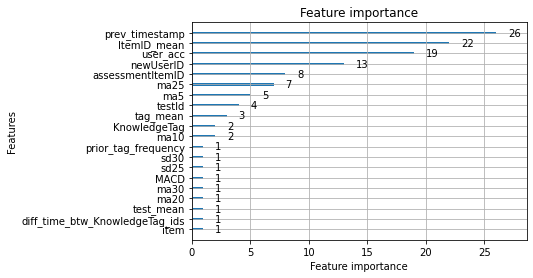

In [422]:
df_train, df_test = PP_train, PP_test

train_grade_group = df_train.groupby("grade")
test_grade_group = df_test.groupby("grade")

grades = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
group_pred = []
smart_auc = 0
for i, grade in enumerate(grades):
    df_train_grade = train_grade_group.get_group(grade)
    df_test_grade = test_grade_group.get_group(grade)
    df_test_grade = df_test_grade[df_test_grade.answerCode == -1]

    df_train_grade, df_val_grade = get_full_valid_split(df_train_grade, train_filter, val_filter, ratio=0.1) 
    print(f"[{i + 1}학년]   train size : {len(df_train_grade)} \n \t test size : {len(df_test_grade)} \n \t val size :  {len(df_val_grade)}")

    pred, auc = group_train(df_train_grade, df_val_grade, df_test_grade, FEATS)
    group_pred.append(pred)
    smart_auc += (auc * (len(df_test_grade) / 744))
print(f" smart auc -> {smart_auc}")


# inference

In [403]:
user2pred = {}

In [404]:
for i, grade in enumerate(grades):
    df_test_grade = test_grade_group.get_group(grade)
    df_test_grade = df_test_grade[df_test_grade.answerCode == -1]
    index_list = list(df_test_grade.index)

    for index, pred in zip(index_list, group_pred[i]):
        user2pred[index] = pred

In [405]:
index_list = list(df_test[df_test.answerCode == -1].index)
total_preds = []
for index in index_list:
    total_preds.append(user2pred[index])

In [406]:
# SAVE OUTPUT
output_dir = './'
prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

write_path = os.path.join(output_dir, f"{prediction_name}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : ./0610_0037.csv


In [407]:
cnt = 0
for pred in total_preds:
    if pred > 0.5:
        cnt+=1

In [408]:
cnt / len(total_preds)

0.4838709677419355